In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from sympy.abc import t
from math import sqrt

In [2]:
#Simulation Functions

def integrate(f, xt, dt, tt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.
    Parameters
    ============
    dyn: Python function
    derivate of the system at a given step x(t),
    it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
    current step x(t)
    dt:
    step size for integration
    Return
    ============
    new_xt:
    value of x(t+dt) integrated from x(t)
    """
    k1 = dt * f(xt,tt)
#     display(k1)
#     display(dt)
#     display(xt)
#     display(tt)
    k2 = dt * f(xt+k1/2.,tt+dt/2.)
    k3 = dt * f(xt+k2/2.,tt+dt/2.)
    k4 = dt * f(xt+k3,tt+dt)
    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    Parameters
    ============
    f: Python function
    derivate of the system at a given step x(t),
    it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
    initial conditions
    tspan: Python list
    tspan = [min_time, max_time], it defines the start and end
    time of simulation
    dt:
    time step for numerical integration
    integrate: Python function
    numerical integration method used in this simulation
    Return
    ============
    x_traj:
    simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt,tvec[i])
        x = np.copy(xtraj[:,i])
    return xtraj

def jack_dyn(s,t):
    """
    s = [theta1,thetadot1]
    returns [thetadot1,thetaddot1]
    """
    return np.array([s[6],s[7],s[8],s[9],s[10],s[11],xjddot_func(*s,t),yjddot_func(*s,t),thjddot_func(*s,t),xbddot_func(*s,t),ybddot_func(*s,t),thbddot_func(*s,t)])
#     return np.array([s[3],s[4],s[5],xjddot_func(*s,t),yjddot_func(*s,t),0])

In [3]:
#function to make sympy rotation matrix
def rot(th):
    rot_mat = sym.Matrix([[sym.cos(th),-sym.sin(th)],[sym.sin(th),sym.cos(th)]])
    return rot_mat

#function to make sympy transformation matrix
def trans(R,p):
    g = sym.Matrix([[R[0],R[1],0,p[0]],[R[2],R[3],0,p[1]],[0,0,1,p[2]],[0,0,0,1]])
    return g

#function to unhat V
def unhat(V):
    return sym.Matrix([V[0,3],V[1,3],V[2,3],V[2,1],-V[2,0],V[1,0]])

#function to calculate inverse of transformation matrix
def mat_inverse(mat):
    R = sym.Matrix([[mat[0,0],mat[0,1],mat[0,2]],
                   [mat[1,0],mat[1,1],mat[1,2]],
                   [mat[2,0],mat[2,1],mat[2,2]]])
    R_inv = R.T
    p = sym.Matrix([mat[0,3],mat[1,3],mat[2,3]])
    p_inv = -R_inv*p
    mat_inv = sym.Matrix([[R_inv[0,0],R_inv[0,1],R_inv[0,2],p_inv[0]],
                         [R_inv[1,0],R_inv[1,1],R_inv[1,2],p_inv[1]],
                         [R_inv[2,0],R_inv[2,1],R_inv[2,2],p_inv[2]],
                         [0,0,0,1]])
    return mat_inv

In [4]:
#Final Project
#Arun Kumar

#Constants
Lb = 10
Wb = 10
Lj = 2
mj = 1
mb = 25
# Jj = 1
# Jb = 1
g = 9.8

#System configuration
xj = sym.Function(r'x_j')(t)
yj = sym.Function(r'y_j')(t)
thj = sym.Function(r'\theta_j')(t)
xb = sym.Function(r'x_b')(t)
yb = sym.Function(r'y_b')(t)
thb = sym.Function(r'\theta_b')(t)
q = sym.Matrix([xj,yj,thj,xb,yb,thb])
qdot = q.diff(t)
qddot = qdot.diff(t)

#Mass config
mb_tot = 4*mb
mj_tot = 4*mj
mb_dist = sqrt(2)*Lb/2
mj_dist = sqrt(2)*Lj/2
Jb = mb_tot*mb_dist
Jj = mj_tot*mj_dist

#Transformations
#Jack
Gwc = trans(rot(q[2]),sym.Matrix([q[0],q[1],0]))
Gcb = trans(rot(0),sym.Matrix([0,-Lj/2,0]))
Gct = trans(rot(0),sym.Matrix([0,Lj/2,0]))
Gcl = trans(rot(0),sym.Matrix([-Lj/2,0,0]))
Gcr = trans(rot(0),sym.Matrix([Lj/2,0,0]))

#box center
Gwc_b = trans(rot(q[5]),sym.Matrix([q[3],q[4],0]))
Gcb_b =trans(rot(0),sym.Matrix([0,-Wb/2,0]))
Gct_b =trans(rot(0),sym.Matrix([0,Wb/2,0]))
Gcr_b =trans(rot(0),sym.Matrix([Lb/2,0,0]))
Gcl_b =trans(rot(0),sym.Matrix([-Lb/2,0,0]))

#world transfromations
Gwb = Gwc*Gcb
Gwl = Gwc*Gcl
Gwr = Gwc*Gcr
Gwt = Gwc*Gct
Gwb_b = Gwc_b*Gcb_b
Gwt_b = Gwc_b*Gct_b
Gwr_b = Gwc_b*Gcr_b
Gwl_b = Gwc_b*Gcl_b

#transform jack frames to center of box frame
Gcc_b = sym.simplify(mat_inverse(Gwc)*Gwc_b)
Gbc_b = sym.simplify(mat_inverse(Gwb)*Gwc_b)
Gtc_b = sym.simplify(mat_inverse(Gwt)*Gwc_b)
Glc_b = sym.simplify(mat_inverse(Gwl)*Gwc_b)
Grc_b = sym.simplify(mat_inverse(Gwr)*Gwc_b)

#contraint transforms
Gbb_b = sym.simplify(mat_inverse(Gwb)*Gwb_b)
Gbt_b = sym.simplify(mat_inverse(Gwb)*Gwt_b)
Gbr_b = sym.simplify(mat_inverse(Gwb)*Gwr_b)
Gbl_b = sym.simplify(mat_inverse(Gwb)*Gwl_b)
Gtb_b = sym.simplify(mat_inverse(Gwt)*Gwb_b)
Gtt_b = sym.simplify(mat_inverse(Gwt)*Gwt_b)
Gtr_b = sym.simplify(mat_inverse(Gwt)*Gwr_b)
Gtl_b = sym.simplify(mat_inverse(Gwt)*Gwl_b)
Grb_b = sym.simplify(mat_inverse(Gwr)*Gwb_b)
Grt_b = sym.simplify(mat_inverse(Gwr)*Gwt_b)
Grr_b = sym.simplify(mat_inverse(Gwr)*Gwr_b)
Grl_b = sym.simplify(mat_inverse(Gwr)*Gwl_b)
Glb_b = sym.simplify(mat_inverse(Gwl)*Gwb_b)
Glt_b = sym.simplify(mat_inverse(Gwl)*Gwt_b)
Glr_b = sym.simplify(mat_inverse(Gwl)*Gwr_b)
Gll_b = sym.simplify(mat_inverse(Gwl)*Gwl_b)


#Body Velocity
Vj = sym.simplify(unhat(mat_inverse(Gwc)*Gwc.diff(t)))
Vb = sym.simplify(unhat(mat_inverse(Gwc_b)*Gwc_b.diff(t)))

#Mass-Inertia
Ij = sym.Matrix([[mj_tot,0.,0.,0.,0.,0.],
               [0.,mj_tot,0.,0.,0.,0.],
               [0.,0.,mj_tot,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,Jj]])
Ij2 = sym.Matrix([[0.,0.,0.],
               [0.,0.,0.],
               [0.,0.,Jj]])
Ib = sym.Matrix([[mb_tot,0.,0.,0.,0.,0.],
               [0.,mb_tot,0.,0.,0.,0.],
               [0.,0.,mb_tot,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,Jb]])
Ib2 = sym.Matrix([[0.,0.,0.],
               [0.,0.,0.],
               [0.,0.,Jb]])


#Kinetic Energy
wj = sym.Matrix([0,0,qdot[2]])
wb = sym.Matrix([0,0,qdot[5]])
# KEj_trans = (0.5*Vj.T*Ij*Vj)[0]
# KEj_rot = (0.5*wj.T*Ij2*wj)[0]
# KEb_trans = (0.5*Vb.T*Ib*Vb)[0]
# KEb_rot = (0.5*wb.T*Ib2*wb)[0]
# KE = KEj_trans+KEj_rot+KEb_trans+KEb_rot
KEj = (0.5*Vj.T*Ij*Vj)[0]
KEb = (0.5*Vb.T*Ib*Vb)[0]
KE = KEj+KEb

#Potential Energy
# PEj = mj*g*q[1]
# PEb = mb*g*q[4]
# PE = PEj+PEb
PE = 0

#Lagrangian
L = sym.simplify(KE-PE)
L_mat = sym.Matrix([L])
display(L)

#Differentiate Lagrangian
dLdq = L.diff(q)
dLdqdot = L.diff(qdot)
ddLdqdotdt = dLdqdot.diff(t)

F_x = 700*sym.sin((2*sym.pi*t)/2)
# F_y = 700*cos((2*pi*t)/2)

F = sym.Matrix([F_x, 0, 0, 0, 0, 0])

#Form EL Equations
zero = sym.zeros(6,1)
el_eqns = sym.Eq(ddLdqdotdt-dLdq,sym.simplify(F))

353.553390593274*Derivative(\theta_b(t), t)**2 + 2.82842712474619*Derivative(\theta_j(t), t)**2 + 50.0*Derivative(x_b(t), t)**2 + 2.0*Derivative(x_j(t), t)**2 + 50.0*Derivative(y_b(t), t)**2 + 2.0*Derivative(y_j(t), t)**2

In [5]:
el_solns = sym.solve(el_eqns,[*qddot])
print('equations solved')

equations solved


In [6]:
#lambdify EL solutions
xjddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[0]])
yjddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[1]])
thjddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[2]])
xbddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[3]])
ybddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[4]])
thbddot_func = sym.lambdify([*q,*qdot,t],el_solns[qddot[5]])

In [7]:
#dummy variables
xjminus, yjminus, thjminus = sym.symbols(r'{x_j}^{-},{y_j}^{-},{\theta_j}^{-}')
xbminus, ybminus, thbminus = sym.symbols(r'{x_b}^{-},{y_b}^{-},{\theta_b}^{-}')
xjdotplus,yjdotplus,thjdotplus,xjdotminus,yjdotminus,thjdotminus = sym.symbols(r'\dot{x_j}^{+},\dot{y_j}^{+},\dot{\theta_j}^{+},\dot{x_j}^{-},\dot{y_j}^{-},\dot{\theta_j}^{-}')
xbdotplus,ybdotplus,thbdotplus,xbdotminus,ybdotminus,thbdotminus = sym.symbols(r'\dot{x_b}^{+},\dot{y_b}^{+},\dot{\theta_b}^{+},\dot{x_b}^{-},\dot{y_b}^{-},\dot{\theta_b}^{-}')
lam = sym.symbols(r'\lambda')

#substitution dictionaries
subs_minus = {q[0]:xjminus,q[1]:yjminus,q[2]:thjminus,q[3]:xbminus,q[4]:ybminus,q[5]:thbminus,qdot[0]:xjdotminus,qdot[1]:yjdotminus,qdot[2]:thjdotminus,qdot[3]:xbdotminus,qdot[4]:ybdotminus,qdot[5]:thbdotminus}
subs_plus = {q[0]:xjminus,q[1]:yjminus,q[2]:thjminus,q[3]:xbminus,q[4]:ybminus,q[5]:thbminus,qdot[0]:xjdotplus,qdot[1]:yjdotplus,qdot[2]:thjdotplus,qdot[3]:xbdotplus,qdot[4]:ybdotplus,qdot[5]:thbdotplus}

#Lagrangian subs
dLdqdot_minus = dLdqdot.subs(subs_minus)
dLdqdot_plus = dLdqdot.subs(subs_plus)

#Hamiltonian
H = dLdqdot.T*qdot-L_mat
H_minus = H.subs(subs_minus)
H_plus = H.subs(subs_plus)

In [8]:
#Constraints
phi1 = sym.Matrix([sym.simplify((mat_inverse(Gbb_b)*sym.Matrix([0,0,0,1]))[1])]) #(bottom jack & bottom box)
phi2 = sym.Matrix([sym.simplify((mat_inverse(Gbt_b)*sym.Matrix([0,0,0,1]))[1])]) #(bottom jack & top box)
phi3 = sym.Matrix([sym.simplify((mat_inverse(Gbr_b)*sym.Matrix([0,0,0,1]))[0])]) #(bottom jack & right box)
phi4 = sym.Matrix([sym.simplify((mat_inverse(Gbl_b)*sym.Matrix([0,0,0,1]))[0])]) #(bottom jack & left box)
phi5 = sym.Matrix([sym.simplify((mat_inverse(Gtb_b)*sym.Matrix([0,0,0,1]))[1])]) #(top jack & bottom box)
phi6 = sym.Matrix([sym.simplify((mat_inverse(Gtt_b)*sym.Matrix([0,0,0,1]))[1])]) #(top jack & top box)
phi7 = sym.Matrix([sym.simplify((mat_inverse(Gtr_b)*sym.Matrix([0,0,0,1]))[0])]) #(top jack & right box)
phi8 = sym.Matrix([sym.simplify((mat_inverse(Gtl_b)*sym.Matrix([0,0,0,1]))[0])]) #(top jack & left box)
phi9 = sym.Matrix([sym.simplify((mat_inverse(Glb_b)*sym.Matrix([0,0,0,1]))[1])]) #(left jack & bottom box)
phi10 = sym.Matrix([sym.simplify((mat_inverse(Glt_b)*sym.Matrix([0,0,0,1]))[1])]) #(left jack & top box)
phi11 = sym.Matrix([sym.simplify((mat_inverse(Glr_b)*sym.Matrix([0,0,0,1]))[0])]) #(left jack & right box)
phi12 = sym.Matrix([sym.simplify((mat_inverse(Gll_b)*sym.Matrix([0,0,0,1]))[0])]) #(left jack & left box)
phi13 = sym.Matrix([sym.simplify((mat_inverse(Grb_b)*sym.Matrix([0,0,0,1]))[1])]) #(right jack & bottom box)
phi14 = sym.Matrix([sym.simplify((mat_inverse(Grt_b)*sym.Matrix([0,0,0,1]))[1])]) #(right jack & top box)
phi15 = sym.Matrix([sym.simplify((mat_inverse(Grr_b)*sym.Matrix([0,0,0,1]))[0])]) #(right jack & right box)
phi16 = sym.Matrix([sym.simplify((mat_inverse(Grl_b)*sym.Matrix([0,0,0,1]))[0])]) #(right jack & left box)
phi_mat = sym.Matrix([phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,phi15,phi16])
phi_mat_minus = phi_mat.subs(subs_minus)
phi_list = [phi1,phi2,phi3,phi4,phi5,phi6,phi7,phi8,phi9,phi10,phi11,phi12,phi13,phi14,phi15,phi16]
for i in range(len(phi_list)):
    display(phi_list[i])

#Impact Update Equations
ieq_list = []
lhs = sym.Matrix([sym.simplify(dLdqdot_plus-dLdqdot_minus),sym.simplify(H_plus-H_minus)])
for i in range(len(phi_list)):
    dpdq = phi_list[i].jacobian(q).T
    dpdq_minus = dpdq.subs(subs_minus)

    #Impact Update Equations
    rhs = sym.Matrix([sym.simplify(lam*dpdq_minus),0])
    ieqs = sym.Eq(lhs,rhs)
    ieq_list.append(ieqs)
print('lists created')

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) - 1.0*cos(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) - 1.0*cos(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) - 1.0*sin(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) - 1.0*sin(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) + 1.0*cos(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) + 1.0*cos(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) + 1.0*sin(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) + 1.0*sin(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) + 1.0*sin(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) + 1.0*sin(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) - 1.0*cos(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) - 1.0*cos(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) - 1.0*sin(\theta_b(t) - \theta_j(t)) + 5.0]])

Matrix([[1.0*x_b(t)*sin(\theta_b(t)) - 1.0*x_j(t)*sin(\theta_b(t)) - 1.0*y_b(t)*cos(\theta_b(t)) + 1.0*y_j(t)*cos(\theta_b(t)) - 1.0*sin(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) + 1.0*cos(\theta_b(t) - \theta_j(t)) - 5.0]])

Matrix([[-1.0*x_b(t)*cos(\theta_b(t)) + 1.0*x_j(t)*cos(\theta_b(t)) - 1.0*y_b(t)*sin(\theta_b(t)) + 1.0*y_j(t)*sin(\theta_b(t)) + 1.0*cos(\theta_b(t) - \theta_j(t)) + 5.0]])

lists created


In [9]:
# phi_funcs = sym.lambdify([xjminus,yjminus,thjminus,xbminus,ybminus,thbminus,
#                          xjdotminus,yjdotminus,thjdotminus,xbdotminus,ybdotminus,thbdotminus],phi_mat_minus,modules = sym)
phi_funcs = []
for condition in phi_list:
    phi_funcs.append(sym.lambdify([[q[0],q[1],q[2],q[3],q[4],q[5],qdot[0],qdot[1],qdot[2],qdot[3],qdot[4],qdot[5]]],condition))

# def impact_condition(s, threshold=(1e-1)*3):
#     phi_val = phi_funcs(*s)
#     for i in range(len(phi_val)):
#         if phi_val[i] < threshold and phi_val[i] > -threshold:
#             return i+1
#     return 0

def impact_condition(s,threshold=1e-1):
    """Check if we have collision
        Input --> s      : configuration state
                phi_funct: list of phi conditions
                threshold: tollerance 
        Output --> int : -1 no impact 
                          if we have impact return the index of phi_funct that we have collision
    """
    i = 0 
    for phi in phi_funcs:
        value = phi(s)
        if value < threshold and value>-threshold:
            return i+1
        i+=1
    return 0
    
def impact_update(s,condition):
    sub_vals = {xjminus:s[0],yjminus:s[0],thjminus:s[0],xbminus:s[0],ybminus:s[0],thbminus:s[0],
               xjdotminus:s[6],yjdotminus:s[7],thjdotminus:s[8],xbdotminus:s[9],ybdotminus:s[10],thbdotminus:s[11]}
    cur_ieqs = ieq_list[condition-1].subs(sub_vals)
    print('solving ieqs')
    print(condition)
    i_sols = sym.solve(cur_ieqs,[lam,xjdotplus,yjdotplus,thjdotplus,xbdotplus,ybdotplus,thbdotplus],dict=True)
    print('solved')
    if len(i_sols) > 1:
        for i in i_sols:
            if abs(i[lam]) < 1e-06:
                pass
            else:
                print('')
                return np.array([s[0],s[1],s[2],s[3],s[4],s[5],float(sym.N(i[xjdotplus])),float(sym.N(i[yjdotplus])),float(sym.N(i[thjdotplus])),float(sym.N(i[xbdotplus])),float(sym.N(i[ybdotplus])),float(sym.N(i[thbdotplus]))])
    else:
        print('wtf')
        return np.array([])

def simulate_with_impact(f,x0,tspan,dt,integrate):
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range (N):
        condition = impact_condition(x)
        if condition != 0:
            x = impact_update(x,condition)
            xtraj[:,i] = integrate(f,x,dt,tvec[i])
        else:
            xtraj[:,i] = integrate(f,x,dt,tvec[i])
        x = np.copy(xtraj[:,i])
    return xtraj

starting simulation
solving ieqs
3
solved

solving ieqs
3
solved

solving ieqs
11
solved

solving ieqs
15
solved

solving ieqs
7
solved

solving ieqs
7
solved

solving ieqs
2
solved

solving ieqs
14
solved

solving ieqs
1
solved

solving ieqs
13
solved

solving ieqs
9
solved

solving ieqs
10
solved

solving ieqs
2
solved

solving ieqs
3
solved

solving ieqs
14
solved

solving ieqs
2
solved

solving ieqs
10
solved



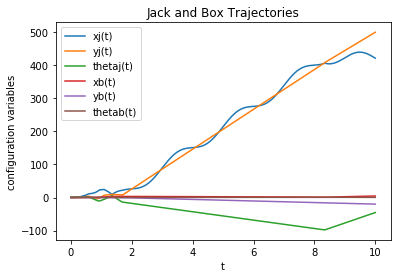

In [10]:
#Run Simulation
print('starting simulation')
s0 = [0,0,np.pi/2,0,0,0,-2,0,0,0,0,0]
tspan = [0,10]
dt = 0.01
N = int((max(tspan)-min(tspan))/dt)
traj = simulate_with_impact(jack_dyn,s0,tspan,dt,integrate)

#Plot
t_list = np.linspace(min(tspan), max(tspan), N)
fig1 = plt.figure(0)
plt.plot(t_list,traj[0])
plt.plot(t_list,traj[1])
plt.plot(t_list,traj[2])
plt.plot(t_list,traj[3])
plt.plot(t_list,traj[4])
plt.plot(t_list,traj[5])
plt.ylabel('configuration variables')
plt.xlabel('t')
plt.legend(['xj(t)','yj(t)','thetaj(t)','xb(t)','yb(t)','thetab(t)'])
plt.title('Jack and Box Trajectories')
plt.show()

In [11]:
def animate_jb(ar,Lj=2,Lb=6,Wb=10,T=10):
    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go
    
    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
                requirejs.config({
                    paths: {
                        base: ’/static/base’,
                        plotly: ’https://cdn.plot.ly/plotly-1.5.1.min.js?noext’,
                    },
                });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)
    
    ###############################################
    # Getting data from trajectories to form Jack and Box
    
    #Center of jack
    xx1 = ar[3]
    yy1 = ar[4]
    
    #jack legs
    xx2 = xx1+(Lj/2)*np.cos(ar[5])
    yy2 = yy1+(Lj/2)*np.sin(ar[5])
    xx3 = xx1-(Lj/2)*np.cos(ar[5])
    yy3 = yy1-(Lj/2)*np.sin(ar[5])
    xx4 = (xx1+(Lj/2)*np.sin(-ar[5]))
    yy4 = yy1+(Lj/2)*np.cos(-ar[5])
    xx5 = (xx1-(Lj/2)*np.sin(-ar[5]))
    yy5 = yy1-(Lj/2)*np.cos(-ar[5])
    
    #Center of box
    xx6 = ar[0]
    yy6 = ar[1]
    
    phi = np.arctan(Wb/Lb)
    z = np.sqrt(Lb**2+Wb**2)/2
    #top right
    xx7 = z*np.cos(ar[2]+phi)+xx6
    yy7 = z*np.sin(ar[2]+phi)+yy6
    #bottom right
    xx8 = xx7+(Wb*np.sin(ar[2]))
    yy8 = yy7-(Wb*np.cos(ar[2]))
    #bottom left
    xx9 = xx6-(xx7-xx6)
    yy9 = yy6-(yy7-yy6)
    #top left
    xx10 = xx6-(xx8-xx6)
    yy10 = yy6-(yy8-yy6)
    

    N = len(theta_array[0]) # Need this for specifying length of simulation
    
    ####################################
    # Using these to specify axis limits.
    xm=-2
    xM=2
    ym=-11
    yM=11

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[dict(x=xx1, y=yy1, 
               mode='lines', name='Jack',
               line=dict(width=2, color='blue')
              ),
          dict(x=xx6, y=yy6, 
               mode='lines', name='Box',
              ),
          
        ]
    
    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Jack in a Box', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    frames=[dict(data=[dict(x=[xx2[k],xx3[k],xx1[k],xx4[k],xx5[k]],
                        y=[yy2[k],yy3[k],yy1[k],yy4[k],yy5[k]],
                        mode='lines',
                        line=dict(color='purple', width=3)
                        ),
                       dict(x=[xx7[k],xx8[k],xx9[k],xx10[k],xx7[k]],
                        y=[yy7[k],yy8[k],yy9[k],yy10[k],yy7[k]],
                        mode='lines',
                        line=dict(color='green', width=3)
                        ),
                    ]) for k in range(N)]
    
    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)


In [17]:
def get_se3_np(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0.0,   x], 
                     [np.sin(theta),  np.cos(theta), 0.0,   y], 
                     [          0.0,            0.0, 1.0, 0.0], 
                     [          0.0,            0.0, 0.0, 1.0]])

In [19]:
# Animate
emp0 = np.zeros(N)
emp1 = np.ones(N)
theta_array = np.array([traj[3],traj[4],traj[5],traj[0],traj[1],traj[2]])
animate_jb(theta_array,Lj=Lj,Wb=Wb,Lb=Lb)